As it is difficult to test the accuracy of the algorithm in the Los Alamos dataset, we will create a artificial dataset for this purpose. A mixture of distributions will denote the possible states each host can be part of for each individual epoch. 

A set of different clusters of hosts will be created. Each set will have hosts, whose points are generated through the same transition matrices.

First we define the states that each data points can be part of. We will use a two dimensional space and a total of 7 total distributions.

In [1]:
import numpy as np

lambdas = np.vstack([[0,0], [15,20], [37,12], [7,48], [55,75], [30,40], [35,25]])
# set the weights of each distributions the same
weights = np.array([1/len(lambdas)] * len(lambdas))

# get random samples from these distributions
# number of points to take from each distribution centroid
size = 1000

for i, lambda_i in enumerate(lambdas):
    s1 = np.random.poisson(lambda_i[0], size)
    s2 = np.random.poisson(lambda_i[1], size)

    if i == 0:
        data = np.column_stack((s1, s2, np.array([i]*size, dtype=object)))
    else:
        data = np.append(data, np.column_stack((s1, s2, np.array([i]*size, dtype=object))), axis=0)

np.random.shuffle(data)

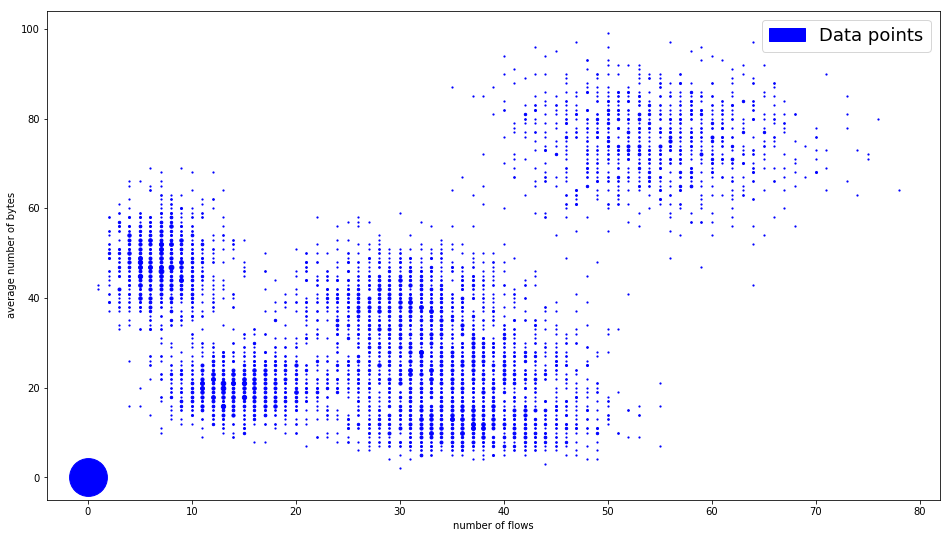

In [2]:
from plots import plot_points
%matplotlib inline

plot_points(data[:, :2])

As we can see most of these cluster are clearly seperated. Some of them are not. This is done on purpose to simulate a real example. From the random samples generated above, we can found the probability that a random sample has the maximum mass function value, for the distribution it originated from.

Let K be the total number of the distributions and J the total number of features we are considering (in our case 2).

Then for the $i^{th}$ sample drawn from the distribution k, the most likely distribution it originated from would be:

$$k_i = \underset{k}{\operatorname{argmax}} f(x_i, l_k)$$

where $$f(x_i, l_k) = \prod_{j=1}^J \frac{(l_{kj})^{x_{ij}} e^{-l_{kj}}}{x_{ij}!}$$

In [3]:
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

predictions = []
true_classes = []
for point in data:
    classification = np.argmax([poisson(point[:2], lambda_i) for lambda_i in lambdas])
    predictions.append(classification)
    true_classes.append(point[2])

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['class ' + str(i) for i in range(len(lambdas))]
print('confusion_matrix: ')
print(confusion_matrix(true_classes, predictions))

print()
print()
print(classification_report(true_classes, predictions, target_names=target_names))

confusion_matrix: 
[[1000    0    0    0    0    0    0]
 [   0  976    6    3    0    3   12]
 [   0    7  942    0    0    0   51]
 [   0    6    0  993    0    1    0]
 [   0    0    0    0  999    1    0]
 [   0    1    0    2    3  900   94]
 [   0   17   52    0    0   74  857]]


             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      1000
    class 1       0.97      0.98      0.97      1000
    class 2       0.94      0.94      0.94      1000
    class 3       0.99      0.99      0.99      1000
    class 4       1.00      1.00      1.00      1000
    class 5       0.92      0.90      0.91      1000
    class 6       0.85      0.86      0.85      1000

avg / total       0.95      0.95      0.95      7000



Now we will create the clusters of the transition matrices.

We will create a number of clusters containing different number of hosts each to stimulate a real example.

The parameter L denotes the total number of these matrices clusters.

In [5]:
import random as ran

L = 14
num_hosts_per_L = [8, 12, 15, 18, 20, 25, 33, 36, 40, 50, 55, 60, 65, 150]

def random_vector(size=7):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=7):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [6]:
transition_matrices = []
for i in range(L):
    transition_matrices.append(random_transition_matrix(size=len(lambdas)))

Create the points for each individual host.

Each host, for the first epoch, has a datapoints at a random distribution. The next datapoint will belong to a new distribution depending on a roulette wheel mechanism and the transition probabilities of the cluster the host belongs to.

In [7]:
data_points = []
number_of_epochs = 500

# creates a random data point for a specified distribution and adds it to the total data points
def add_random_points(data_points, host_name, distribution, lambdas, epoch):
    axis0 = np.random.poisson(lambdas[distribution][0], 1)[0]
    axis1 = np.random.poisson(lambdas[distribution][1], 1)[0]
    data_points.append([axis0, axis1, epoch, host_name])

def random_next_state(transition_matrices, i, previous_distribution):
    r = ran.random()
    return np.where(transition_matrices[i][previous_distribution].cumsum() >= r)[0][0]
    
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        # random starting distribution
        previous_distribution = ran.randint(0, len(lambdas) - 1)
        add_random_points(data_points, host_name, previous_distribution, lambdas, 1)
        
        for k in range(2, number_of_epochs + 1):
            next_distribution = random_next_state(transition_matrices, i, previous_distribution)
            
            add_random_points(data_points, host_name, next_distribution, lambdas, k)
            
            previous_distribution = next_distribution
            

data_points = np.array(data_points,  dtype=object)

Run the EM Algorithm and the clustering

An important note is that initial EM mixtures center points, might have some differences to the desired final points, so on the starting epochs some of the results might not be the desired ones. This should not be a problem though.

In [8]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

Select some random data points as the initial ones.

In [31]:
mixtures = len(lambdas)

kplusplus = KPlusPlus(mixtures, data_points[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7


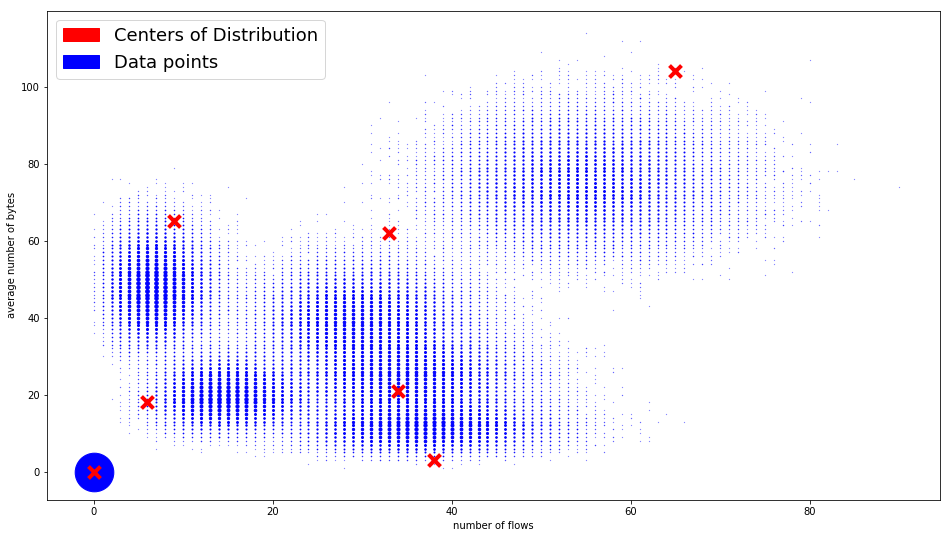

In [32]:
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, sum(num_hosts_per_L), verbose=0, update_power=0.5)

# the initial data points
plot_points(data_points[:, :2], onlineEM)

In [33]:
onlineEM.fit(data_points[:,[0,1,3]])

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:205: RuntimeWarning: invalid value encountered in true_divide
  previous)
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


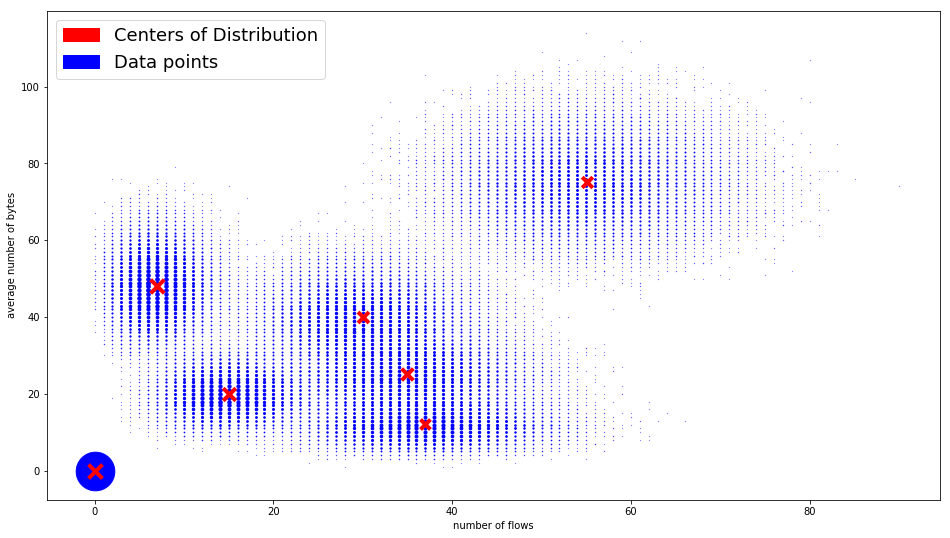

In [34]:
# the final data points
plot_points(data_points[:, :2], onlineEM)

In [35]:
print(onlineEM.gammas)
print(onlineEM.lambdas)

[ 0.13602889  0.11176761  0.19333244  0.18392581  0.11963064  0.15751014
  0.09780447]
[[34.898810663506701 25.115487807070345]
 [55.03884156100618 75.235726976065223]
 [0.0 0.0]
 [7.0135846486166393 47.980540779046812]
 [30.073549699670483 39.929531725930964]
 [15.005872109741544 19.984473377475314]
 [36.936022512610833 12.127030642721211]]


The transition matrices will be initialized to the following table (normalized to 1):

initializer:

|  |
| :-------------: |:-------------:| :-----:|
| 1  | 0.5 | ... | 0.5 | 
| 0.5  | 1 | ... | 0.5 | 
| ...  | ... | ... | .. | 
| 0.5  | 0.5 | ... | 1 | 


The final transition matrix will be:

$$\frac{initializer}{num\_points + 1} + \frac{transition\_matrix * num\_points}{num\_points + 1}$$ for each individual row.

This is done manually in the following cells but in the final version of the algorithm will be done automatically

In [36]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [37]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

Now we can cluster the transition matrices.

In [38]:
from klkmeans import kl_kMeans

kmeans = kl_kMeans(onlineEM, n_clusters=L, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run()

Starting run
The cost is 115.907280412
The cost is 67.2730513309


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\klkmeans.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  total_distance += P[i] * log(P[i]/Q[i])


The cost is 66.5582738309
The cost is 66.4775870245
The cost is 66.4215784416
The cost is 66.2475066161
The cost is 66.0101235255
converged
Starting run
The cost is 111.50686688
The cost is 78.4312097526
The cost is 60.4916230402
The cost is 59.7638260629
converged
Starting run
The cost is 106.417225777
The cost is 72.3718768391
The cost is 62.4260340021
The cost is 62.4002010646
The cost is 62.3798305299
The cost is 62.350618494
converged
Starting run
The cost is 134.328915045
The cost is 64.6707568598
The cost is 62.7658863785
The cost is 62.2843061586
The cost is 62.2606006289
The cost is 62.2471076795
The cost is 62.2414486029
The cost is 62.2321635051
converged
Starting run
The cost is 116.50163323
The cost is 92.6397135157
The cost is 76.1239668241
The cost is 76.0053632746
converged
Starting run
The cost is 124.288982154
The cost is 74.2823665324
The cost is 69.5437835086
The cost is 69.4643275084
The cost is 69.4176789214
The cost is 69.4093865063
The cost is 69.3900356771
The 

In [39]:
centroids = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = assign[host_name]
        centroids[i][participation] += 1
    
print(centroids)

[[  0   0   0   0   0   0   0   0   0   8   0   0   0   0]
 [  0   0  12   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  15   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  18   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  20   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  25]
 [  0   0   0   0   0   0   0  33   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  36   0   0   0]
 [  0   0   0   0   0   0   0   0  40   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  50   0   0]
 [  0  55   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 60   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  65   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 150   0]]


Calculate the Purity

$$ Purity = \frac{1}{N} \sum_{i=1}^k max_j |c_i ∩ t_j|$$

where $c_i$ is the class the host belongs to and $t_j$ the cluster it was assigned to

In [40]:
total = sum(num_hosts_per_L)

pure = np.sum(np.max(centroids, axis=1))

print('Purity in the clusters is', pure/total)

Purity in the clusters is 1.0


We will now compare this method to merely classifying hosts based on the clusters their data points can be found

For this case we will cluster the vectors containing for each host where their points can be located

In [41]:
participations = []
for host in onlineEM.hosts:
    participations.append(onlineEM.hosts[host]['points_per_cluster'])

In [42]:
from sklearn.cluster import KMeans

kmeans_points = KMeans(n_clusters=L, random_state=0).fit(participations)

In [43]:
centroids_points = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = kmeans_points.predict([onlineEM.hosts[host_name]['points_per_cluster']])[0]
        centroids_points[i][participation] += 1
    
print(centroids_points)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  8  0]
 [11  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0 13  0  0  0]
 [ 3 14  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  1  0  0 21  0  1]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 32]
 [ 0  0  0 36  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0 38  0  0  0  0  0  0  0]
 [ 0  0 49  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 54  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 59  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  2  0  0  0 13  0  0  0]
 [11  0  0  0  0 62  0  0  0 77  0  0  0  0]]


In [44]:
total = sum(num_hosts_per_L)

pure = np.sum(np.max(centroids_points, axis=1))

print('Purity in the clusters is', pure/total)

Purity in the clusters is 0.821124361158
